In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np

C:\Users\jorge.ruiz\Anaconda3\envs\quant\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
C:\Users\jorge.ruiz\Anaconda3\envs\quant\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\Users\jorge.ruiz\Anaconda3\envs\quant\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\Users\jorge.ruiz\Anaconda3\envs\quant\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.

In [3]:

model = keras.models.load_model("reg_linear_out.h5")
train_x = np.arange(-10, 10, 0.01).astype(np.float32)

# quantize the model with tflite 


In [10]:
def representative_data_gen():

  tracks_datagen = np.array(train_x)
  np.random.shuffle(tracks_datagen)
  for input_value in tracks_datagen[:500]:
    # Model has only one input so each data point has one element.
    yield [input_value]

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8 (APIs added in r2.3)
#converter.inference_input_type =  tf.int8
#converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\JORGE~1.RUI\AppData\Local\Temp\tmpzqmi1m5c\assets


INFO:tensorflow:Assets written to: C:\Users\JORGE~1.RUI\AppData\Local\Temp\tmpzqmi1m5c\assets
C:\Users\jorge.ruiz\Anaconda3\envs\quant\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [4]:
import pathlib

tflite_models_dir = pathlib.Path("./quant")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"test_quant.tflite"
#tflite_model_quant_file.write_bytes(tflite_model_quant)

In [6]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file), experimental_preserve_all_tensors=True)
interpreter.allocate_tensors()


In [7]:
res = []
for real_value in train_x:
    input_details = interpreter.get_input_details()
    x = np.array(real_value).astype(np.float32)
    x = np.array(x).reshape(1, 1)
    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()
    output_details = interpreter.get_output_details()
    result = interpreter.get_tensor(output_details[0]['index'])
    res.append(result[0])

res = np.array(res)
expected = np.abs(train_x)
# add 1 dim to expected:
expected = np.expand_dims(expected, axis=1)

print(res.shape)
# mse between res and train_x




print("MSE: ", np.mean((expected[0] - res[0]) ** 2))

(2000, 1)
MSE:  0.017790461


In [18]:
print(res)
print("MAE = ", np.mean(np.abs(expected - res)))
print(np.sum(np.abs(expected-res)))
print("MSE", np.mean((np.subtract(expected, res)) ** 2))

[[9.866619]
 [9.866619]
 [9.866619]
 ...
 [9.905464]
 [9.905464]
 [9.905464]]
MAE =  0.087425545
174.85109
MSE 0.012754733


In [19]:
from itertools import groupby
def interpolate_noise(arr: np.ndarray):
    

    res = []

    for k, g in groupby(arr):
        segment = [None] * len(list(g))
        segment[len(segment)  // 2] = k
        res.extend(segment)

    #res = np.array(res, dtype=object)

    x = np.array(res, dtype="float32")

    xp = [i for i, yi in enumerate(x) if np.isfinite(yi)]
    fp = [yi for i, yi in enumerate(x) if np.isfinite(yi)]
    return np.interp(x=list(range(len(x))), xp=xp, fp=fp)

interpolated = interpolate_noise(res)
interpolated = np.expand_dims(interpolated, axis=1)
print(res.shape)
print(interpolated.shape)
expected = np.expand_dims(np.abs(train_x), axis=1)
print("Interpolated MSE", np.mean((interpolated - expected) ** 2))

(2000, 1)
(2000, 1)
Interpolated MSE 0.008502923026497406


C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_15612\1744635638.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  x = np.array(res, dtype="float32")


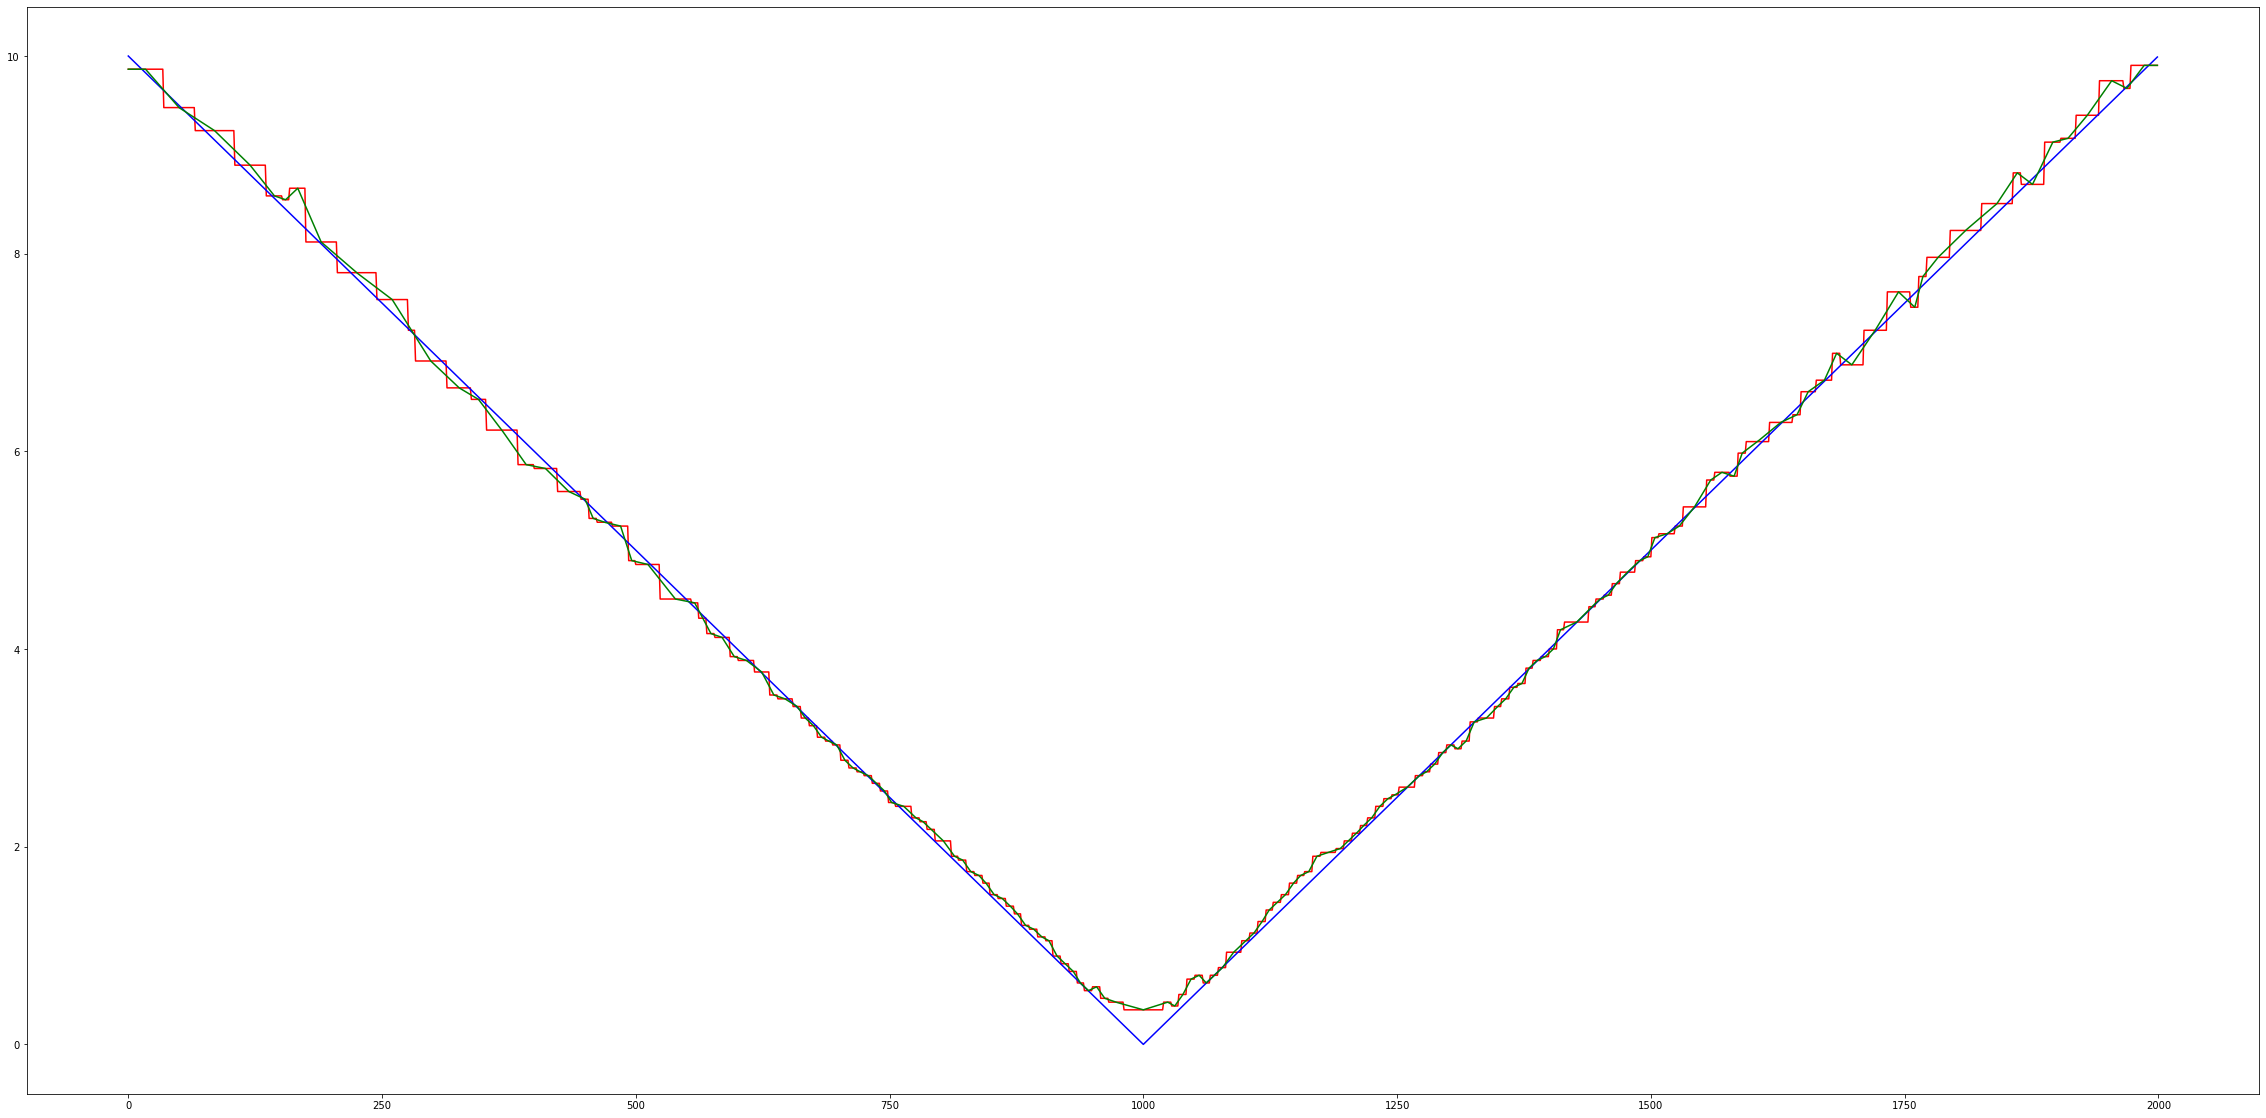

In [16]:
# plot res:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
plt.plot(res, 'r')
plt.plot(np.abs(train_x), 'b')
plt.plot(interpolated, 'g')
# plt bigger plot 



plt.show()
